In [1]:

import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/hj19/anaconda3/envs/spoof/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

In [79]:
data=pd.read_csv('ETTh1.csv')

In [92]:
data[data['date']=='2017-12-01 00:00:00']

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
12432,2017-12-01 00:00:00,11.855,4.555,9.559,2.63,2.376,1.097,3.517


In [87]:
data[train_size:train_size+val_size]

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
10452,2017-09-09 12:00:00,-5.693,0.737,-9.061,-0.995,2.772,1.340,16.108999
10453,2017-09-09 13:00:00,-12.324,2.746,-14.427,1.031,2.863,1.127,16.250000
10454,2017-09-09 14:00:00,-9.176,2.009,-11.940,0.497,2.589,1.097,17.305000
10455,2017-09-09 15:00:00,-4.220,0.804,-6.894,-0.497,2.315,0.944,17.094000
10456,2017-09-09 16:00:00,-2.277,0.000,-5.259,-0.959,2.650,1.066,17.375999
...,...,...,...,...,...,...,...,...
13931,2018-02-01 11:00:00,5.291,2.545,1.031,1.492,4.325,0.914,4.713000
13932,2018-02-01 12:00:00,-9.377,3.081,-13.326,1.350,3.625,0.914,4.291000
13933,2018-02-01 13:00:00,1.608,2.746,-2.310,1.599,4.112,1.157,4.291000
13934,2018-02-01 14:00:00,-7.502,3.081,-11.336,1.386,3.594,1.188,6.261000


In [205]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
values = data[data.columns[1:]].values.reshape(-1,7)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

#scaled= (values-mean(values))/std(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [206]:
#train_size = 9504
#val_size = 12432-9504

train_size=int(len(data)*0.8)
val_size=int(len(data)*0.1)


test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:train_size+2*val_size,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

13936 1742 1742 3484


In [207]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [208]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

13912
1718
1718
3460


In [209]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back: i+ look_back+predict, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [210]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

13744
1550
1550


In [168]:
trainX.shape

(13744, 168, 7)

In [131]:
from tensorflow.keras.layers import LeakyReLU


In [225]:
first_input = Input(shape=(168,7))


in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64,activation='elu', kernel_size=3,padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)
#in0=selu()(in0)

in1=Conv1D(filters=64, activation='elu',kernel_size=3,padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1=SeLU()(in1)

in1=Conv1D(filters=64,activation='elu', kernel_size=1,padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=SeLU()(in1)

ad=add([in0,in1],name='extractor')

#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64,activation='elu', kernel_size=3,padding='same')(ad)
#in1= BatchNormalization(scale=False)(in0)
#in0=SeLU()(in0)

in1=Conv1D(filters=64,activation='elu', kernel_size=3,padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1=SeLU()(in1)

in1=Conv1D(filters=64,activation='elu', kernel_size=1,padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=SeLU()(in1)

ad1=add([in0,in1],name='extractor1')


#in0=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(ad1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([ad1,in1],name='extractor2')
#in0=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1])

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
in1=Flatten()(ad1)
in1=Dropout(0.5)(in1)
#in1=SeLU()(in1)

#in1=Dense(100, activation='relu')(in1)
out=Dense(24,activation='elu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/ETT_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 168, 7)]     0                                            
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 168, 64)      18432       input_35[0][0]                   
__________________________________________________________________________________________________
conv1d_151 (Conv1D)             (None, 168, 64)      12352       lstm_34[0][0]                    
__________________________________________________________________________________________________
conv1d_152 (Conv1D)             (None, 168, 64)      12352       conv1d_151[0][0]                 
___________________________________________________________________________________________

In [226]:
hist = model.fit([trainX],trainY, epochs = 50,validation_data=([valX],valY),batch_size=100, verbose = 1,callbacks=[cb])

Train on 13744 samples, validate on 1550 samples
Epoch 1/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0355
Epoch 00001: val_loss improved from inf to 0.05947, saving model to saved_weights/ETT_multistep.hdf5
13744/13744 [==============================] - 15s 1ms/sample - loss: 0.0354 - val_loss: 0.0595
Epoch 2/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0241
Epoch 00002: val_loss did not improve from 0.05947
13744/13744 [==============================] - 13s 946us/sample - loss: 0.0241 - val_loss: 0.0597
Epoch 3/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0227
Epoch 00003: val_loss improved from 0.05947 to 0.05597, saving model to saved_weights/ETT_multistep.hdf5
13744/13744 [==============================] - 13s 952us/sample - loss: 0.0227 - val_loss: 0.0560
Epoch 4/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0217
Epoch 00004: val_loss improved from 0.05597 to 0.05520, saving model to saved_

13700/13744 [============================>.] - ETA: 0s - loss: 0.0062
Epoch 00035: val_loss did not improve from 0.05414
13744/13744 [==============================] - 13s 946us/sample - loss: 0.0062 - val_loss: 0.0836
Epoch 36/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0060
Epoch 00036: val_loss did not improve from 0.05414
13744/13744 [==============================] - 13s 944us/sample - loss: 0.0060 - val_loss: 0.0841
Epoch 37/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 00037: val_loss did not improve from 0.05414
13744/13744 [==============================] - 13s 945us/sample - loss: 0.0059 - val_loss: 0.0815
Epoch 38/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 00038: val_loss did not improve from 0.05414
13744/13744 [==============================] - 13s 942us/sample - loss: 0.0056 - val_loss: 0.0828
Epoch 39/50
13700/13744 [============================>.] - ETA: 0s - loss: 0.0056
Epoch 

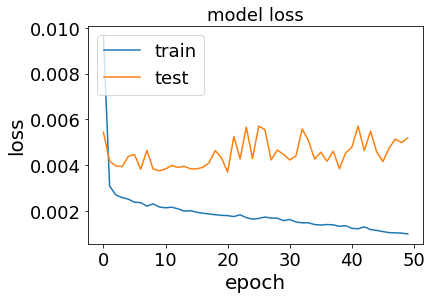

In [154]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [103]:
model.load_weights('saved_weights/ETT_onestep_1.hdf5')

OSError: Unable to open file (unable to open file: name = 'saved_weights/ETT_onestep.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

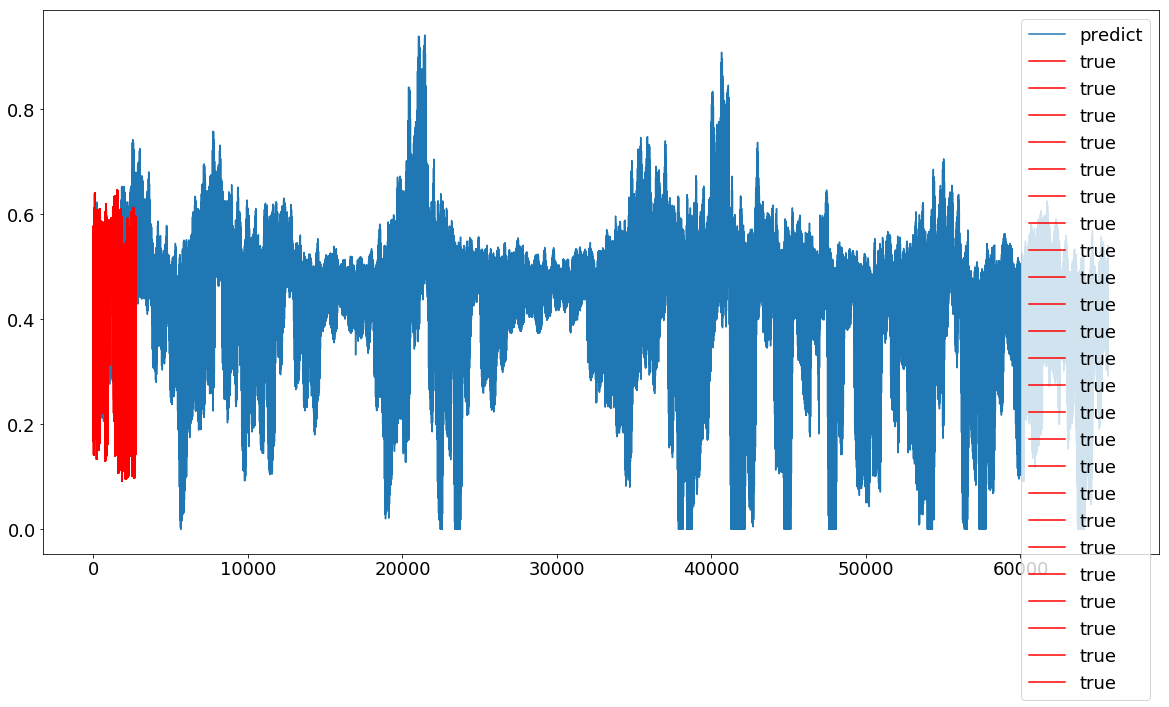

ValueError: Found input variables with inconsistent numbers of samples: [2736, 65664]

In [104]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))


pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
mse=mean_squared_error(yhat_inverse, testY_inverse)

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MSE: %.5f' % mse)


In [219]:
model.load_weights('saved_weights/ETT_multistep.hdf5')

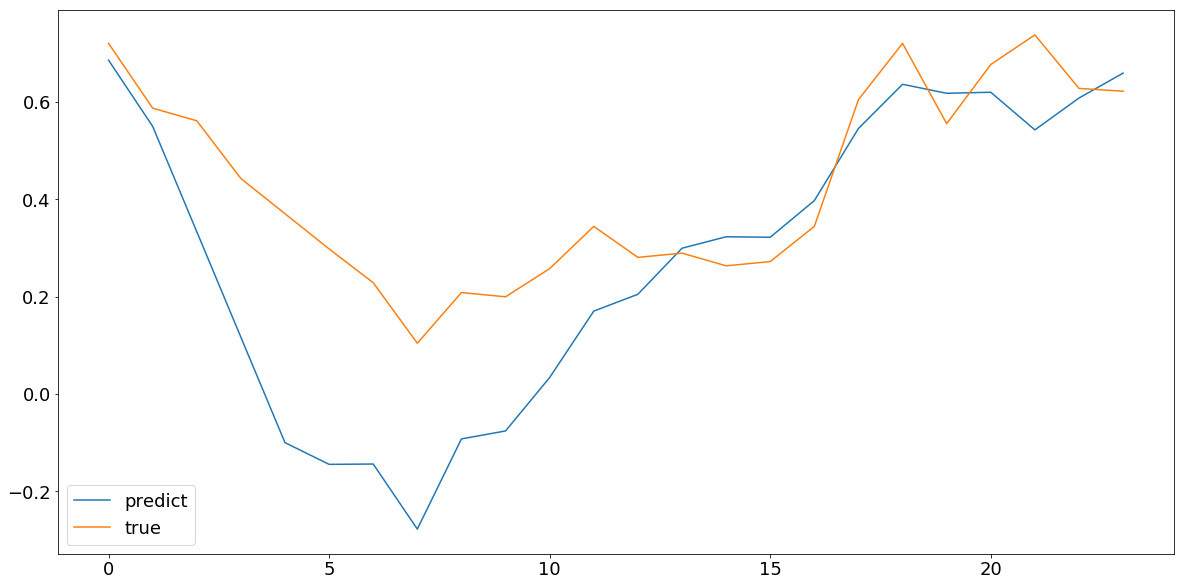

Test RMSE: 0.22169
Test MAE: 0.16780
Test MSE: 0.04914


ValueError: non-broadcastable output operand with shape (24,1) doesn't match the broadcast shape (24,7)

In [224]:
from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
plt.figure(figsize=(20,10))
yhat=yhat[24]
testy=testY[24]
yhat=yhat.reshape(-1,1)
testy=testy.reshape(-1,1)
pyplot.plot(yhat, label='predict')
pyplot.plot(testy, label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testy, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testy, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testy, yhat)
print('Test MSE: %.5f' % mse)

#yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
#testY_inverse=testy*(np.max(values)-np.min(values))+np.min(values)

yhat_inverse=scaler.inverse_transform(yhat)
testY_inverse=scaler.inverse_transform(testY)
rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
mae=mean_absolute_error(yhat_inverse, testY_inverse)
mse=mean_squared_error(yhat_inverse, testY_inverse)

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MSE: %.5f' % mse)


<Figure size 1440x720 with 0 Axes>

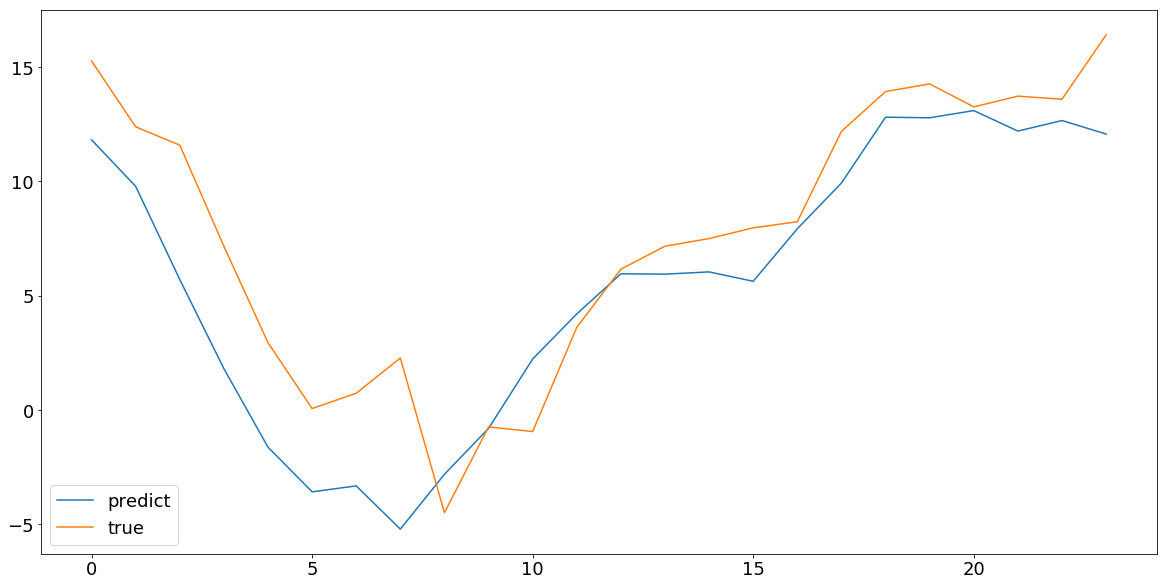

In [67]:
plt.figure(figsize=(20,10))

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='true')
pyplot.legend()
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

pyplot.show()



In [68]:
np.min(data['OT'])

-4.079999923706056